In [1]:
%pip install keras


Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 348.8 kB/s eta 0:00:0000:0100:09
  Using cached wrapt-1.16.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (80 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 807.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 657.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 551.8 kB/s eta 0:00:0000:0100:02
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 512.4 kB/s eta 0:00:0000:0100:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 514.4 kB/s eta 0:00:0000:0100:01
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Preparing metadata (setup.py) ... done
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2

In [5]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()


2024-06-27 16:39:26.587491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 16:39:27.811445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step


In [28]:
import numpy as np
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [29]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self._shuffle()
        self.current_idx = 0

    def _shuffle(self):
        p = np.random.permutation(len(self.X))
        self.X, self.y = self.X[p], self.y[p]

    def __len__(self):
        return len(self.X) // self.batch_size

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_idx >= len(self):
            self._shuffle()
            self.current_idx = 0
            raise StopIteration
        idx = self.current_idx * self.batch_size
        self.current_idx += 1
        return self.X[idx:idx + self.batch_size], self.y[idx:idx + self.batch_size]


In [31]:
class ScratchSimpleNeuralNetworkClassifier():
    def __init__(self, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, learning_rate=0.01, sigma=0.01, verbose=True):
        self.verbose = verbose
        self.lr = learning_rate
        self.sigma = sigma
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)
        self.B1 = np.zeros(n_nodes1)
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.B2 = np.zeros(n_nodes2)
        self.W3 = sigma * np.random.randn(n_nodes2, n_output)
        self.B3 = np.zeros(n_output)

    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def _softmax(self, X):
        exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)

    def _cross_entropy_error(self, y, t):
        delta = 1e-7
        return -np.sum(t * np.log(y + delta)) / y.shape[0]
    
    def fit(self, X, y, X_val=None, y_val=None, epochs=50, batch_size=20):
        for epoch in range(epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                # Forward Propagation
                A1 = np.dot(mini_X_train, self.W1) + self.B1
                Z1 = self._sigmoid(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self._sigmoid(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                Z3 = self._softmax(A3)

                # Back Propagation
                dA3 = (Z3 - mini_y_train) / batch_size
                self.W3 -= self.lr * np.dot(Z2.T, dA3)
                self.B3 -= self.lr * np.sum(dA3, axis=0)

                dZ2 = np.dot(dA3, self.W3.T) * Z2 * (1 - Z2)
                self.W2 -= self.lr * np.dot(Z1.T, dZ2)
                self.B2 -= self.lr * np.sum(dZ2, axis=0)

                dZ1 = np.dot(dZ2, self.W2.T) * Z1 * (1 - Z1)
                self.W1 -= self.lr * np.dot(mini_X_train.T, dZ1)
                self.B1 -= self.lr * np.sum(dZ1, axis=0)

            if self.verbose:
                A1 = np.dot(X_val, self.W1) + self.B1
                Z1 = self._sigmoid(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self._sigmoid(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                Z3 = self._softmax(A3)
                loss = self._cross_entropy_error(Z3, y_val)
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')


    def predict(self, X):
        A1 = np.dot(X, self.W1) + self.B1
        Z1 = self._sigmoid(A1)
        A2 = np.dot(Z1, self.W2) + self.B2
        Z2 = self._sigmoid(A2)
        A3 = np.dot(Z2, self.W3) + self.B3
        Z3 = self._softmax(A3)
        return np.argmax(Z3, axis=1)

In [32]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data
X_train = X_train.reshape((X_train.shape[0], -1)) / 255.0
X_test = X_test.reshape((X_test.shape[0], -1)) / 255.0

# One-hot encode the labels
enc = OneHotEncoder(sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])


In [33]:
# Create the neural network classifier
clf = ScratchSimpleNeuralNetworkClassifier(verbose=True)

# Train the model
clf.fit(X_train, y_train_one_hot, X_val=X_test, y_val=y_test_one_hot, epochs=10, batch_size=32)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10, Loss: 2.304662455570403
Epoch 2/10, Loss: 2.3050963422029698
Epoch 3/10, Loss: 2.3031641949545265
Epoch 4/10, Loss: 2.3050799579728
Epoch 5/10, Loss: 2.3047547670162962
Epoch 6/10, Loss: 2.302021522781697
Epoch 7/10, Loss: 2.2959677239305245
Epoch 8/10, Loss: 2.290299685929612
Epoch 9/10, Loss: 2.2535367350531685
Epoch 10/10, Loss: 1.9808930008262
Test Accuracy: 0.2911


In [34]:
# Display a couple of images with their predicted labels
def display_images(X, y_true, y_pred, num_images=2):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_true[i]}, Pred: {y_pred[i]}')
        plt.axis('off')
    plt.show()


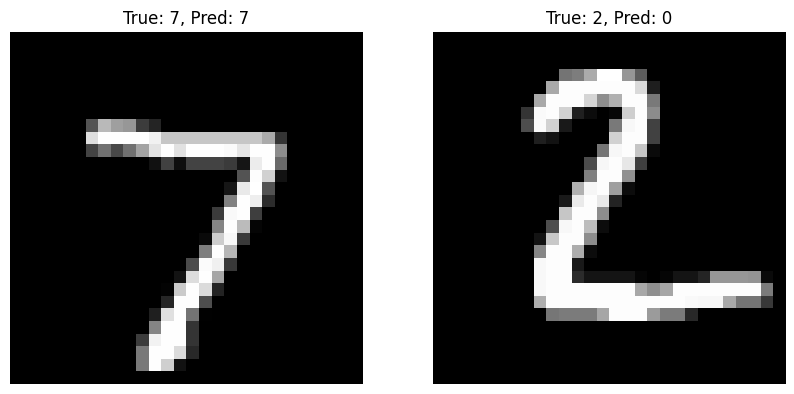

In [35]:
display_images(X_test, y_test, y_pred, num_images=2)